<a href="https://colab.research.google.com/github/dvignoles/nyc-transpo/blob/master/nyc_transpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
from datetime import datetime
import numpy as np
import requests, zipfile, io, os, re, csv
import matplotlib.pyplot as plt

TAXI_CSV_PATH = "./taxi_data"
BIKE_CSV_PATH = "./bike_data"

# We will use with 2013-2018 June data since June 2013 is when Citi Bike was started, and 2013-2018 data is available for both taxi and bikes.
# We will also filter down to the first week of the month, because the data is an absolute unit
YEARS = ["2013", "2014", "2015", "2016", "2017", "2018"]

In [60]:
# Set up directories and util functions to store the downloaded csv files

if os.path.isdir(TAXI_CSV_PATH) is False:
  os.mkdir(TAXI_CSV_PATH)
if os.path.isdir(BIKE_CSV_PATH) is False:
  os.mkdir(BIKE_CSV_PATH)

  
def save_csv(file_path, http_data):
    with open(file_path, "w") as f:
      writer = csv.writer(f)
      reader = csv.reader(http_data.text.splitlines())
      for row in reader:
        writer.writerow(row)
        
def get_csv_name(data_type, year, two_weeks_only=False):
  if data_type is "taxi":
    return TAXI_CSV_PATH + "/" + year + "-06" + ("_parsed" if two_weeks_only is True else "") +  ".csv"
  elif data_type is "bike":
    return BIKE_CSV_PATH + "/" + year + "-06" + ("_parsed" if two_weeks_only is True else "") + ".csv"
  else:
    raise Exception("Data type must be taxi or bike")

# Taxi Dataframes
Since these downloads take a long time, do NOT reset all run times when it asks you to! It will wipe all downloaded files, and you'll have to download them again!

In [194]:
# Download and save the files first so they don't have to be redownloaded every time

for n in YEARS:
  file_path = get_csv_name("taxi", n, False)
  if os.path.isfile(file_path) is False:
    data = requests.get("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + n + "-06.csv")
    save_csv(file_path, data)

# Load the actual data

dtypes = {
    "vendor_id": "str",
    "VendorID": "str",
    "pickup_datetime": "str",
    "dropoff_datetime": "str",
    "tpep_pickup_datetime": "str",
    "tpep_dropoff_datetime": "str",
    "passenger_count": np.int32,
    "trip_distance": np.float32,
    "pickup_longitude": np.float32,
    "pickup_latitude": np.float32,
    "PULocationID": np.int32,
    "DOLocationID": np.int32,
    "rate_code": np.int32,
    "RateCodeID": np.int32,
    "store_and_fwd_flag": "str",
    "dropoff_longitude": np.float32,
    "dropoff_latitude": np.float32,
    "payment_type": "str",
    "fare_amount": np.float32,
    "surcharge": np.float32,
    "mta_tax": np.float32,
    "tip_amount": np.float32,
    "tolls_amount": np.float32,
    "total_amount": np.float32
}

def get_parsed_taxi_df(year):
  # See if the sorted data was saved before, if so use it
  sorted_file_path = get_csv_name("taxi", year, True)
  if os.path.isfile(sorted_file_path) is True:
    df_toreturn = pd.read_csv(sorted_file_path, dtype=dtypes)
    df_toreturn['pickup_datetime_parsed'] = pd.to_datetime(df_toreturn['pickup_datetime_parsed'])
    return df_toreturn
  
  # Otherwise, load the full file, sort it, and save it for future reference
  df_temp = pd.read_csv(get_csv_name("taxi", year, False), dtype=dtypes)
  
  # Sort by date
  df_temp.sort_values(by=df_temp.columns[1], inplace=True, kind='mergesort')
  df_temp['pickup_datetime_parsed'] = pd.to_datetime(df_temp.iloc[:,1])
  
  # Get only the first week of the month
  df_temp = df_temp[(df_temp['pickup_datetime_parsed'] > (year + '-06-01')) & (df_temp['pickup_datetime_parsed'] < (year + '-06-08'))]
  df_temp.to_csv(sorted_file_path)
  return df_temp
  
# The util function MUST be used to save memory while loading in the entire dataframes for each year.
# IGNORE MEMORY LIMIT WARNINGS! The data is garbage collected every time the function exits for each year.

df_taxi_2013 = get_parsed_taxi_df("2013")
df_taxi_2014 = get_parsed_taxi_df("2014")
df_taxi_2015 = get_parsed_taxi_df("2015")
df_taxi_2016 = get_parsed_taxi_df("2016")
df_taxi_2017 = get_parsed_taxi_df("2017")
df_taxi_2018 = get_parsed_taxi_df("2018")

In [195]:
# convert pickup and dropoff to datetime object
# then add trip duration column
# standardize pickup/dropoff column names.

if not('tripduration' in df_taxi_2013.columns):
    df_taxi_2013['pickup_datetime'] = pd.to_datetime(df_taxi_2013['pickup_datetime'])
    df_taxi_2013['dropoff_datetime'] = pd.to_datetime(df_taxi_2013['dropoff_datetime'])
    df_taxi_2013['tripduration'] = (df_taxi_2013['dropoff_datetime'] - df_taxi_2013['pickup_datetime']).dt.total_seconds()

if not('tripduration' in df_taxi_2014.columns):
    df_taxi_2014['pickup_datetime'] = pd.to_datetime(df_taxi_2014[' pickup_datetime'])
    df_taxi_2014['dropoff_datetime'] = pd.to_datetime(df_taxi_2014[' dropoff_datetime'])
    df_taxi_2014['tripduration'] = (df_taxi_2014['dropoff_datetime'] - df_taxi_2014['pickup_datetime']).dt.total_seconds()
    df_taxi_2014.drop(columns=[' pickup_datetime', ' dropoff_datetime'])

if not('tripduration' in df_taxi_2015.columns):
    df_taxi_2015['pickup_datetime'] = pd.to_datetime(df_taxi_2015['tpep_pickup_datetime'])
    df_taxi_2015['dropoff_datetime'] = pd.to_datetime(df_taxi_2015['tpep_dropoff_datetime'])
    df_taxi_2015['tripduration'] = (df_taxi_2015['dropoff_datetime'] - df_taxi_2015['pickup_datetime']).dt.total_seconds()
    df_taxi_2015.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

if not('tripduration' in df_taxi_2016.columns):
    df_taxi_2016['pickup_datetime'] = pd.to_datetime(df_taxi_2016['tpep_pickup_datetime'])
    df_taxi_2016['dropoff_datetime'] = pd.to_datetime(df_taxi_2016['tpep_dropoff_datetime'])
    df_taxi_2016['tripduration'] = (df_taxi_2016['dropoff_datetime'] - df_taxi_2016['pickup_datetime']).dt.total_seconds()
    df_taxi_2016.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

if not('tripduration' in df_taxi_2017.columns):
    df_taxi_2017['pickup_datetime'] = pd.to_datetime(df_taxi_2017['tpep_pickup_datetime'])
    df_taxi_2017['dropoff_datetime'] = pd.to_datetime(df_taxi_2017['tpep_dropoff_datetime'])
    df_taxi_2017['tripduration'] = (df_taxi_2017['dropoff_datetime'] - df_taxi_2017['pickup_datetime']).dt.total_seconds()
    df_taxi_2017.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

if not('tripduration' in df_taxi_2018.columns):
    df_taxi_2018['pickup_datetime'] = pd.to_datetime(df_taxi_2018['tpep_pickup_datetime'])
    df_taxi_2018['dropoff_datetime'] = pd.to_datetime(df_taxi_2018['tpep_dropoff_datetime'])
    df_taxi_2018['tripduration'] = (df_taxi_2018['dropoff_datetime'] - df_taxi_2018['pickup_datetime']).dt.total_seconds()
    df_taxi_2018.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [206]:
def clean_col_names(names):
    '''remove leading whitespace + spaces from column names'''
    clean_names = []
    for name in names:
        name = name.lstrip()
        name = name.replace(' ','_')
        clean_names.append(name)
    return(clean_names)

In [211]:
df_taxi_all  = [df_taxi_2013,df_taxi_2014,df_taxi_2015,df_taxi_2016,df_taxi_2017,df_taxi_2018]

for df in df_taxi_all:
    df.columns = clean_col_names(df.columns)

# Citi Bike Dataframes
Since Citi Bike does not directly provide csv files, we must handle the zip files, extract, and load them accordingly.

In [64]:
reg_pattern = re.compile("^\d+.*\.csv$")

for n in YEARS:
  # See if the file exists
  file_path = get_csv_name("bike", n)
  if os.path.isfile(file_path) is True:
    continue

  # If not, request and save it
  req_url = ""
  if n != "2017" and n != "2018":
    req_url = "https://s3.amazonaws.com/tripdata/" + n + "06-citibike-tripdata.zip"
  else:
    req_url = "https://s3.amazonaws.com/tripdata/" + n + "06-citibike-tripdata.csv.zip"
    
  # Handle the ZIP
  z = zipfile.ZipFile(io.BytesIO(requests.get(req_url).content))
  orig_file_name = list(filter(reg_pattern.match, z.namelist()))[0]
  z.extract(orig_file_name)
  os.rename(orig_file_name, get_csv_name("bike", n)) # Renaming the file will automatically remove the original, extracted file

In [65]:
# The dtypes can't be passed in atm because some columns that should be integers have non-number strings in them
# Some columns that should be integers are floats instead because pandas can't put NaN values in integer columns
"""
dtypes = {
    "tripduration": np.int32,
    "starttime": "str",
    "stoptime": "str",
    "start station id": np.float32,
    "start station name": "str",
    "start station latitude": np.float32,
    "start station longitude": np.float32,
    "end station id": np.float32,
    "end station name": "str",
    "end station latitude": np.float32,
    "end station longitude": np.float32,
    "bikeid": np.int32,
    "usertype": "str",
    "birth year": np.float32,
    "gender": np.int32
}
"""


df_bike_2013_orig = pd.read_csv(get_csv_name("bike", "2013"))
df_bike_2014_orig = pd.read_csv(get_csv_name("bike", "2014"))
df_bike_2015_orig = pd.read_csv(get_csv_name("bike", "2015"))
df_bike_2016_orig = pd.read_csv(get_csv_name("bike", "2016"))
df_bike_2017_orig = pd.read_csv(get_csv_name("bike", "2017"))
df_bike_2018_orig = pd.read_csv(get_csv_name("bike", "2018"))

In [66]:
# Convert to datetime. This was really annoying with the different formats - if the format is unspecified, the functions never stop running.
# Also must assert that the last row of data has a start time greater than the second week, to make sure we have the full first 2 weeks of data

# 2013
df_bike_2013_orig['starttime_parsed'] = pd.to_datetime(df_bike_2013_orig['starttime'])
df_bike_2013_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2013_orig['stoptime'])
assert df_bike_2013_orig.iloc[-1].starttime_parsed > datetime.strptime('2013-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2013"

# 2014
df_bike_2014_orig['starttime_parsed'] = pd.to_datetime(df_bike_2014_orig['starttime'])
df_bike_2014_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2014_orig['stoptime'])
assert df_bike_2014_orig.iloc[-1].starttime_parsed > datetime.strptime('2014-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2014"

# 2015
df_bike_2015_orig['starttime_parsed'] = pd.to_datetime(df_bike_2015_orig["starttime"], format="%m/%d/%Y %H:%M")
df_bike_2015_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2015_orig['stoptime'], format="%m/%d/%Y %H:%M")
assert df_bike_2015_orig.iloc[-1].starttime_parsed > datetime.strptime('2015-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2015"

# 2016
df_bike_2016_orig['starttime_parsed'] = pd.to_datetime(df_bike_2016_orig['starttime'], format="%m/%d/%Y %H:%M:%S")
df_bike_2016_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2016_orig['stoptime'], format="%m/%d/%Y %H:%M:%S")
assert df_bike_2016_orig.iloc[-1].starttime_parsed > datetime.strptime('2016-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2016"

# 2017
df_bike_2017_orig['starttime_parsed'] = pd.to_datetime(df_bike_2017_orig['starttime'], format="%Y-%m-%d %H:%M:%S")
df_bike_2017_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2017_orig['stoptime'], format="%Y-%m-%d %H:%M:%S")
assert df_bike_2017_orig.iloc[-1].starttime_parsed > datetime.strptime('2017-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2017"

# 2018
df_bike_2018_orig['starttime_parsed'] = pd.to_datetime(df_bike_2018_orig['starttime'], format="%Y-%m-%d %H:%M:%S")
df_bike_2018_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2018_orig['stoptime'], format="%Y-%m-%d %H:%M:%S")
assert df_bike_2018_orig.iloc[-1].starttime_parsed > datetime.strptime('2018-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2018"

In [67]:
# Our main Citi Bike dataframes we'll be using, with a full week of data for each year

df_bike_2013 = df_bike_2013_orig[(df_bike_2013_orig['starttime_parsed'] > '2013-06-01') & (df_bike_2013_orig['starttime_parsed'] < '2013-06-08')]
df_bike_2014 = df_bike_2014_orig[(df_bike_2014_orig['starttime_parsed'] > '2014-06-01') & (df_bike_2014_orig['starttime_parsed'] < '2014-06-08')]
df_bike_2015 = df_bike_2015_orig[(df_bike_2015_orig['starttime_parsed'] > '2015-06-01') & (df_bike_2015_orig['starttime_parsed'] < '2015-06-08')]
df_bike_2016 = df_bike_2016_orig[(df_bike_2016_orig['starttime_parsed'] > '2016-06-01') & (df_bike_2016_orig['starttime_parsed'] < '2016-06-08')]
df_bike_2017 = df_bike_2017_orig[(df_bike_2017_orig['starttime_parsed'] > '2017-06-01') & (df_bike_2017_orig['starttime_parsed'] < '2017-06-08')]
df_bike_2018 = df_bike_2018_orig[(df_bike_2018_orig['starttime_parsed'] > '2018-06-01') & (df_bike_2018_orig['starttime_parsed'] < '2018-06-08')]


In [129]:
df_bike_all = [df_bike_2013,df_bike_2014,df_bike_2015,df_bike_2017,df_bike_2018]

### Taxi Zones

In [69]:
import shapefile
with shapefile.Reader("./taxi_zones/geo_export_a619f821-072d-486f-8172-0c1be3f7e97d") as shp:
    shapes = shp.shapes()
    
    fields = shp.fields
    
    records = shp.records()


In [70]:
keep_fields = ['borough','location_i','shape_area','zone']

In [136]:
class Zone:
    def __init__(self,location_id,name,borough,area,bbox):
            self.location_id = location_id
            self.name = name
            self.borough = borough
            self.area = area
            self.bbox = bbox
    
    def __repr__(self):
        return str((self.location_id,self.name,self.borough,self.area,self.bbox))
    
    def __str__(self):
        return(self.name + ' : ' + str(self.bbox))
        
ZONES = [] #List of all Zone objects 
ZONES_DIC = {} #Dictionary of all zones with location_id at key

for i in range(0,len(shapes)):
    z = Zone(records[i].location_i,records[i].zone,records[i].borough,records[i].shape_area,shapes[i].bbox)
    ZONES.append(z)
    ZONES_DIC[str(z.location_id)] = z

In [137]:
def zone_lookup(lon,lat):
    for z in ZONES:
        
        w_lon = z.bbox[0]
        s_lat = z.bbox[1]
        e_lon = z.bbox[2]
        n_lat = z.bbox[3]
        
        if lat >= s_lat and lat <= n_lat:
            if lon >= w_lon and lon <= e_lon:
                return(z)
    return None

In [138]:
def zone_lookup_id(lon,lat):
    z = zone_lookup(lon,lat)
    
    if z:
        return z.location_id
    else:
        return None

In [159]:
def add_zones(df):
    df['zone_from'] = np.vectorize(zone_lookup_id)(df.pickup_longitude,df.pickup_latitude)
    df['zone_to'] = np.vectorize(zone_lookup_id)(df.dropoff_longitude,df.dropoff_latitude)

add_zones(df_taxi_2013)

AttributeError: 'DataFrame' object has no attribute 'pickup_longitude'

['Unnamed: 0',
 'VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'pickup_datetime_parsed',
 'pickup_datetime',
 'dropoff_datetime',
 'tripduration',
 'day']

# Analysis

## Exploratory Data Analysis

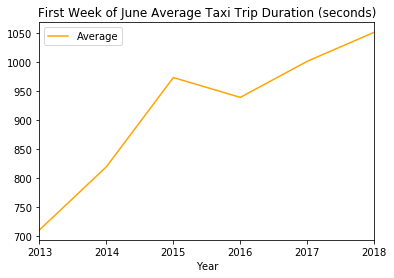

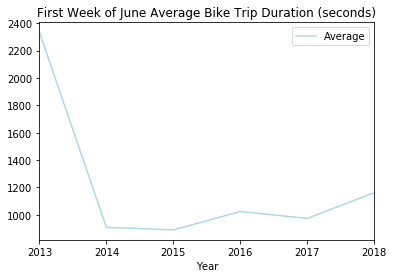

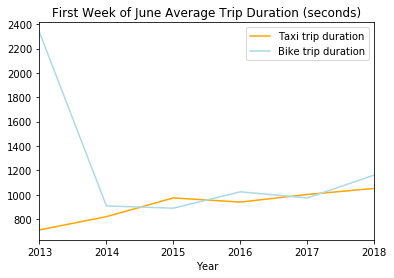

In [73]:
# Create average trip duration dataframes and plot

avg_trip_duration_bike = pd.DataFrame(
    {'Year': YEARS, 
     'Average': [
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] 
    })

avg_trip_duration_taxi = pd.DataFrame(
    {'Year': YEARS,
     'Average': [
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]
    })

avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Taxi Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Bike Trip Duration (seconds)', color='lightblue')

_ = avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', ax=_, color='lightblue')
_.legend(['Taxi trip duration', 'Bike trip duration'])

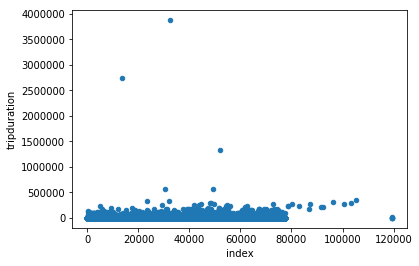

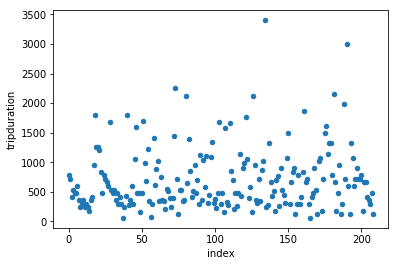

In [74]:
# quick scatter plot--exposes some weird outliers.  
# CitiBike has some >1000 hour trips
# Cabs have some negative time durations

df_bike_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

df_taxi_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

In [75]:
# had to avoid 2014 here, as there are some issues with the birthdate field in that dataframe. Will clean.
# yo people in their 40s love citibikes

citi_avg_age = []

citi_avg_age.append(df_bike_2013["birth year"].mean())
citi_avg_age.append("NaN")
citi_avg_age.append(df_bike_2015["birth year"].mean())
citi_avg_age.append(df_bike_2016["birth year"].mean())
citi_avg_age.append(df_bike_2017["birth year"].mean())
citi_avg_age.append(df_bike_2018["birth year"].mean())

print(citi_avg_age)

[1973.7418080639952, 'NaN', 1976.2964147385587, 1977.4734717561873, 1978.7014382409977, 1978.7112451471332]


### Number of Trips

In [76]:
# Using .loc everywhere here to try to remove the SettingsWithCopyWarning, but still happens unfortunately. No idea how to fix
df_taxi_2013.loc[:,'day'] = df_taxi_2013.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2014.loc[:,'day'] = df_taxi_2014.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2015.loc[:,'day'] = df_taxi_2015.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2016.loc[:,'day'] = df_taxi_2016.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2017.loc[:,'day'] = df_taxi_2017.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2018.loc[:,'day'] = df_taxi_2018.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))

df_bike_2013.loc[:,'day'] = df_bike_2013.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2014.loc[:,'day'] = df_bike_2014.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2015.loc[:,'day'] = df_bike_2015.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2016.loc[:,'day'] = df_bike_2016.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2017.loc[:,'day'] = df_bike_2017.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2018.loc[:,'day'] = df_bike_2018.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))

/home/dan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/dan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


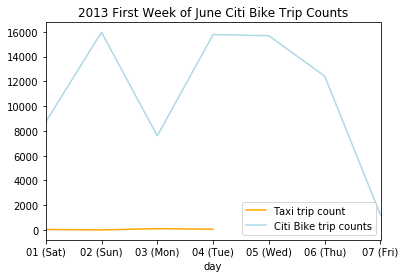

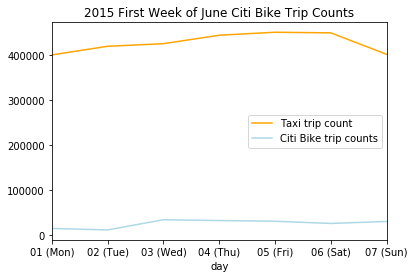

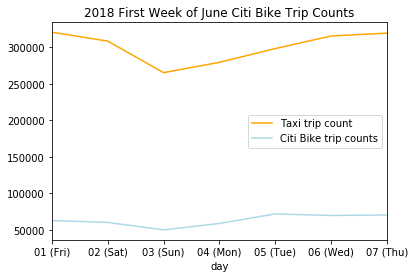

In [77]:
first_plot = df_taxi_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Taxi Trip Counts', color='orange')
df_bike_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Taxi Trip Counts', color='orange')
df_bike_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Taxi Trip Counts', color='orange')
df_bike_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

In [78]:
# Make new data frames for yearly trip counts, and graph them

df_taxi_trip_counts = pd.DataFrame({'Year': YEARS, 'Count': [
    df_taxi_2013.groupby(by='day').size().sum(),
    df_taxi_2014.groupby(by='day').size().sum(),
    df_taxi_2015.groupby(by='day').size().sum(),
    df_taxi_2016.groupby(by='day').size().sum(),
    df_taxi_2017.groupby(by='day').size().sum(),
    df_taxi_2018.groupby(by='day').size().sum(),
]})

df_bike_trip_counts = pd.DataFrame({'Year': YEARS, 'Count': [
    df_bike_2013.groupby(by='day').size().sum(),
    df_bike_2014.groupby(by='day').size().sum(),
    df_bike_2015.groupby(by='day').size().sum(),
    df_bike_2016.groupby(by='day').size().sum(),
    df_bike_2017.groupby(by='day').size().sum(),
    df_bike_2018.groupby(by='day').size().sum(),
]})

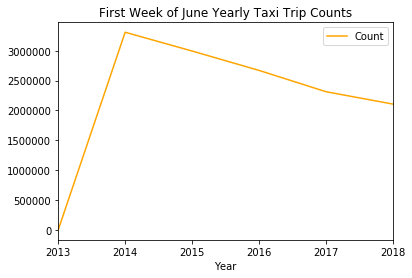

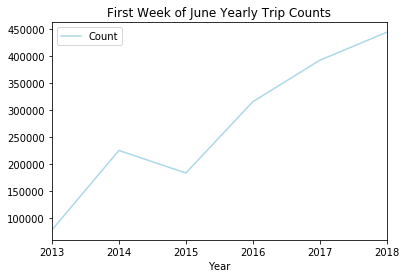

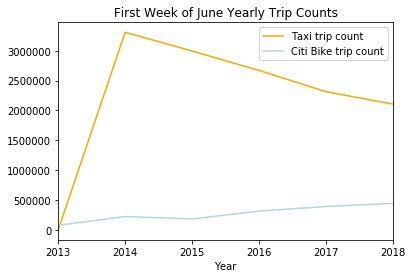

In [79]:
df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', color='lightblue') 

first_plot = df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip count'])